<a href="https://colab.research.google.com/github/mfilipak/AFRAC_IA/blob/main/005B_Experimentos_usando_CNN_para_representar_descri%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EM CONSTRUÇÃO

# Experimento 005B
##Objetivo: Experimentos e reprodução de trabalhos com word embeddings usando como corpo o campo de descrição (até 120 caracteres com ou sem padding). Com foco em CNN 1D e redes siamesas. Espera-se que tenha um bom potencial de agrupar palavras por GTIN, NCM entre outros.
##Fonte dos dados: dataset público do portal da transparência - Campos de descrição e NCM.


#Referências:
* https://arxiv.org/pdf/1509.01626.pdf - Character-level Convolutional Networks for Text Classification - Esse paper é um bom ponto de partida. Tem a coparticipação do Yann LeCun, criador das CNNs.
* https://github.com/ahmedbesbes/character-based-cnn - Implementação do paper acima.
* https://www.youtube.com/watch?v=CNY8VjJt-iQ - Vídeo explicando a implementação do Ahmed para o paper.
* https://aclanthology.org/W16-1617.pdf - Não pretendo usar essa nesse experimento mas é um bom ponto de partida caso se queira usar RNN em uma rede siamesa.
* http://aclanthology.lst.uni-saarland.de/P16-1036.pdf - Abordagem semelhante usando redes siamesas para encontrar perguntas semelhantes no QUORA.
* https://www.kaggle.com/c/quora-question-pairs/discussion/33631
* https://explosion.ai/blog/quora-deep-text-pair-classification - Bom artigo embora não seja orientado a CNNs.
* https://github.com/BrambleXu/nlp-beginner-guide-keras/blob/master/char-level-cnn/char_cnn.py - Outra implementação, essa em Keras.
* https://arxiv.org/pdf/1408.5882.pdf - Classificação de sentenças, comparando CNN com outras técnicas. Um pouco outdated (2015)
*<b> https://towardsdatascience.com/character-level-cnn-with-keras-50391c3adf33 - Mais uma implementação em Keras - ponto de partida para esse notebook</b>
* https://repositorio.pucrs.br/dspace/bitstream/10923/15243/2/Measuring_Semantic_Similarity_Between_Sentences_Using_a_Siamese_Neural_Network.pdf - Paper de alguns autores Brasileiros da PUC RS usa rede siamesa com arquitetura GRU.


#Dica: Altere o tipo de runtime para usar GPU, os treinos desse notebook são relativamente pesados para rodar em CPU.<br><br>
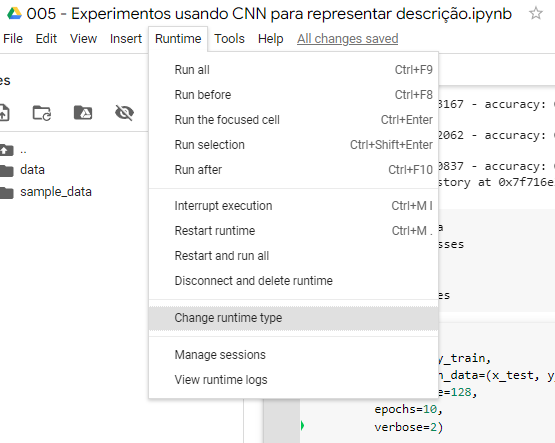

In [17]:
import requests
import os
import pandas as pd

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Embedding, Activation, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [71]:
#Copia os dados das NFEs do portal da cidadância pro drive virtual.
import requests  
file_url = "https://raw.githubusercontent.com//mfilipak/AFRAC_IA/main/DATASET/202201_NFe_NotaFiscalItem.zip"
r = requests.get(file_url, stream = True) 

with open("portal.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

DATA_FILE = "portal.zip"
df = pd.read_csv(DATA_FILE, encoding="CP1252",sep=";")
print("O dataframe completo contém:",len(df),"linhas")

df3 = df[['DATA EMISSÃO','DESCRIÇÃO DO PRODUTO/SERVIÇO', 'CÓDIGO NCM/SH', 'CFOP']]
df3.columns = ["DATA", "DESCR", "NCM", "CFOP"]
df3 = df3[df3["NCM"]!=-1] #Filtrando NCMs = -1

text_lengths = np.array([len(_) for _ in df3['DESCR']])
df3 = df3[text_lengths>=3]

#Caso queira eliminar as repetições rodar a linha abaixo
df3 = df3.drop_duplicates(subset=["DESCR", "NCM", "CFOP"])
print("O dataframe sem repetiçoes contém:",len(df3),"linhas")
df3[:1]

O dataframe completo contém: 324056 linhas
O dataframe sem repetiçoes contém: 155038 linhas


,DATA,DESCR,NCM,CFOP
0,01/01/2022 00:02:22,HP RESERVATORIO DE RESIDUO DE TONER,84439939,6949


In [73]:
descs = [_.lower() for _ in df3["DESCR"]]
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(descs)
print(tk.word_index)
print(f"{len(tk.word_index)} caracteres.")
print("".join(sorted([_ for _ in tk.word_index])))
descs = [_+(120-len(_))*" " for _ in descs]
df3["DESCR_NORM"] = descs
df3[-5:]

{'UNK': 1, ' ': 2, 'a': 3, 'o': 4, 'e': 5, 'r': 6, 'i': 7, 't': 8, 'c': 9, 'l': 10, 'm': 11, 's': 12, 'n': 13, '0': 14, 'd': 15, 'p': 16, 'u': 17, '1': 18, '2': 19, 'g': 20, 'b': 21, 'f': 22, 'v': 23, '-': 24, '5': 25, '3': 26, '.': 27, 'x': 28, '4': 29, '/': 30, 'h': 31, ',': 32, '6': 33, '8': 34, '7': 35, '9': 36, ':': 37, 'k': 38, 'z': 39, 'j': 40, 'q': 41, '(': 42, ')': 43, 'w': 44, 'y': 45, '|': 46, 'ç': 47, 'ã': 48, '#': 49, '%': 50, "'": 51, '+': 52, 'á': 53, '*': 54, ';': 55, 'ó': 56, 'í': 57, 'é': 58, '$': 59, '_': 60, 'ê': 61, '=': 62, 'â': 63, 'º': 64, '?': 65, 'ú': 66, ']': 67, '[': 68, '&': 69, '\\': 70, '°': 71, 'ô': 72, '>': 73, 'õ': 74, '²': 75, 'à': 76, 'ø': 77, '!': 78, '~': 79, '<': 80, '`': 81, 'ª': 82, 'µ': 83, '®': 84, '³': 85, '@': 86, '©': 87, '¾': 88, '}': 89, '{': 90, '¡': 91, 'è': 92, '\xad': 93, 'ì': 94, '\x7f': 95, 'ò': 96, 'ü': 97, 'þ': 98, 'ù': 99}
99 caracteres.
 !#$%&'()*+,-./0123456789:;<=>?@UNK[\]_`abcdefghijklmnopqrstuvwxyz{|}~¡©ª­®°²³µº¾àáâãçèéêìíò

,DATA,DESCR,NCM,CFOP,DESCR_NORM
324044,31/01/2022 23:54:45,FAROL DE MILHA ESQUERDO / DIREITO,85149000,5405,farol de milha esquerdo / direito ...
324045,31/01/2022 23:54:45,FAROL LADO ESQUERDO/ DIREITO,85149000,5405,farol lado esquerdo/ direito ...
324046,31/01/2022 23:54:45,CUBO DE RODA DIANT DIREITO / ESQUERDO,87089529,5405,cubo de roda diant direito / esquerdo ...
324048,31/01/2022 23:55:00,POLTRONA PRESIDENTE GIRATORIA,94021000,6102,poltrona presidente giratoria ...
324053,31/01/2022 23:59:59,Leite Cru Refrigerado,4014010,1135,leite cru refrigerado ...


In [74]:
df3["DESCR_NORM"].values

array(['hp reservatorio de residuo de toner                                                                                     ',
       'mltd201lxaz cartucho de toner preto 20k paginas                                                                         ',
       'cltc609sxaz cartucho de toner ciano 7k paginas                                                                          ',
       ...,
       'cubo de roda diant direito / esquerdo                                                                                   ',
       'poltrona presidente giratoria                                                                                           ',
       'leite cru refrigerado                                                                                                   '],
      dtype=object)

https://classificadorfiscal.com.br/uploads/1/0/6/1/106125045/secaoecap.html

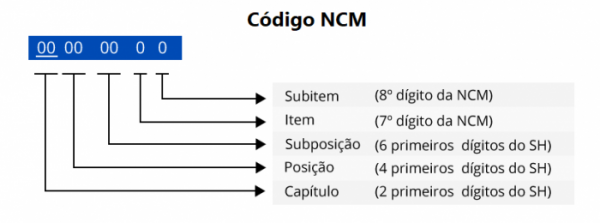

In [120]:
capitulos = [ int(f"{_:08}"[:2]) for _ in df3["NCM"] ]
df3["CAPITULO"] = capitulos
print(f"Capítulos encontrados no NCM: {len(df3['CAPITULO'].unique())}")

Capítulos encontrados no NCM: 98


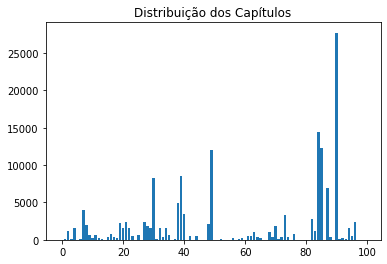

In [149]:
#df3.count("CAPITULO")
import matplotlib.pyplot as plt
plt.title("Distribuição dos Capítulos")
plt.bar(df3["CAPITULO"].value_counts().index, df3["CAPITULO"].value_counts().values)
plt.show()

In [150]:
# Convert string to index
X_sequences = tk.texts_to_sequences(descs)
X = np.array(X_sequences, dtype='float32')
X.shape

(155038, 120)

In [157]:
Y = to_categorical(capitulos)
Y.shape

(155038, 100)

In [2]:
#Cria pastas e copia os arquivos externos de dataset pro drive virtual.
os.makedirs('./data/ag_news_csv', exist_ok=True)

def GetExternalFile(file_url, file_path):
  r = requests.get(file_url, stream = True) 
  with open(file_path, "wb") as file:  
      for block in r.iter_content(chunk_size = 1024): 
          if block:  
              file.write(block)

GetExternalFile("https://raw.githubusercontent.com/BrambleXu/nlp-beginner-guide-keras/master/char-level-cnn/data/ag_news_csv/test.csv", 
                "./data/ag_news_csv/test.csv")
GetExternalFile("https://raw.githubusercontent.com/BrambleXu/nlp-beginner-guide-keras/master/char-level-cnn/data/ag_news_csv/train.csv", 
                "./data/ag_news_csv/train.csv")

pd.read_csv("./data/ag_news_csv/test.csv", header=None)[-3:]

,0,1,2
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...
7599,3,EBay gets into rentals,EBay plans to buy the apartment and home renta...


In [3]:
# ========================Load data=========================


train_data_source = './data/ag_news_csv/train.csv'
test_data_source = './data/ag_news_csv/test.csv'

train_df = pd.read_csv(train_data_source, header=None)
test_df = pd.read_csv(test_data_source, header=None)

# concatenate column 1 and column 2 as one text
for df in [train_df, test_df]:
    df[1] = df[1] + df[2]
    df = df.drop([2], axis=1)

# convert string to lower case
train_texts = train_df[1].values
train_texts = [s.lower() for s in train_texts]

test_texts = test_df[1].values
test_texts = [s.lower() for s in test_texts]

# =======================Convert string to index================
# Tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(train_texts)
# If we already have a character list, then replace the tk.word_index
# If not, just skip below part

# -----------------------Skip part start--------------------------
# construct a new vocabulary
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

# Use char_dict to replace the tk.word_index
tk.word_index = char_dict.copy()
# Add 'UNK' to the vocabulary
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1
# -----------------------Skip part end----------------------------

# Convert string to index
train_sequences = tk.texts_to_sequences(train_texts)
test_texts = tk.texts_to_sequences(test_texts)

# Padding
train_data = pad_sequences(train_sequences, maxlen=1014, padding='post')
test_data = pad_sequences(test_texts, maxlen=1014, padding='post')

# Convert to numpy array
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

# =======================Get classes================
train_classes = train_df[0].values
train_class_list = [x - 1 for x in train_classes]

test_classes = test_df[0].values
test_class_list = [x - 1 for x in test_classes]

train_classes = to_categorical(train_class_list)
test_classes = to_categorical(test_class_list)

In [4]:
print(tk.word_index)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36, ',': 37, ';': 38, '.': 39, '!': 40, '?': 41, ':': 42, "'": 43, '"': 44, '/': 45, '\\': 46, '|': 47, '_': 48, '@': 49, '#': 50, '$': 51, '%': 52, '^': 53, '&': 54, '*': 55, '~': 56, '`': 57, '+': 58, '-': 59, '=': 60, '<': 61, '>': 62, '(': 63, ')': 64, '[': 65, ']': 66, '{': 67, '}': 68, 'UNK': 69}


In [5]:
train_df[1].values[0], train_texts[0], train_data[0][:30]

("Wall St. Bears Claw Back Into the Black (Reuters)Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 "wall st. bears claw back into the black (reuters)reuters - short-sellers, wall street's dwindling\\band of ultra-cynics, are seeing green again.",
 array([23.,  1., 12., 12., 69., 19., 20., 39., 69.,  2.,  5.,  1., 18.,
        19., 69.,  3., 12.,  1., 23., 69.,  2.,  1.,  3., 11., 69.,  9.,
        14., 20., 15., 69.], dtype=float32))

In [6]:
train_class_list[0], train_classes[0]

(2, array([0., 0., 1., 0.], dtype=float32))

In [7]:
vocab_size = len(tk.word_index)
vocab_size

69

In [8]:
embedding_weights = [] #(71, 70)
embedding_weights.append(np.zeros(vocab_size)) # first row is pad

for char, i in tk.word_index.items(): # from index 1 to 70
    onehot = np.zeros(vocab_size)
    onehot[i-1] = 1
    embedding_weights.append(onehot)
embedding_weights = np.array(embedding_weights)

In [9]:
print(embedding_weights.shape) # first row all 0 for PAD, 69 char, last row for UNK
embedding_weights

(70, 69)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
# parameter 
input_size = 1014
# vocab_size = 69
embedding_size = 69
conv_layers = [[256, 7, 3], 
               [256, 7, 3], 
               [256, 3, -1], 
               [256, 3, -1], 
               [256, 3, -1], 
               [256, 3, 3]]

fully_connected_layers = [1024, 1024]
num_of_classes = 4
dropout_p = 0.5
optimizer = 'adam'
loss = 'categorical_crossentropy'

In [11]:
# Embedding layer Initialization
embedding_layer = Embedding(vocab_size+1, 
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

In [12]:
# Model 

# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 1014)
# Embedding 
x = embedding_layer(inputs)
# Conv 
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x) 
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x) # Final shape=(None, 34, 256)
x = Flatten()(x) # (None, 8704)
# Fully connected layers 
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x) # dense_size == 1024
    x = Dropout(dropout_p)(x)
# Output Layer
predictions = Dense(num_of_classes, activation='softmax')(x)
# Build model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) # Adam, categorical_crossentropy
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1014)]            0         
                                                                 
 embedding (Embedding)       (None, 1014, 69)          4830      
                                                                 
 conv1d (Conv1D)             (None, 1008, 256)         123904    
                                                                 
 activation (Activation)     (None, 1008, 256)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 336, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 330, 256)          459008    
                                                             

In [13]:
# 1000 training samples and 100 testing samples
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)

x_train = train_data[indices][:1000]
y_train = train_classes[indices][:1000]

x_test = test_data[:100]
y_test = test_classes[:100]

In [14]:
# Training
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=128,
          epochs=10,
          verbose=2)

Epoch 1/10
8/8 - 15s - loss: 1.3925 - accuracy: 0.2690 - val_loss: 1.3597 - val_accuracy: 0.3500 - 15s/epoch - 2s/step
Epoch 2/10
8/8 - 1s - loss: 1.3845 - accuracy: 0.2800 - val_loss: 1.3675 - val_accuracy: 0.3700 - 692ms/epoch - 87ms/step
Epoch 3/10
8/8 - 1s - loss: 1.3784 - accuracy: 0.3010 - val_loss: 1.3439 - val_accuracy: 0.4200 - 690ms/epoch - 86ms/step
Epoch 4/10
8/8 - 1s - loss: 1.3846 - accuracy: 0.2890 - val_loss: 1.3718 - val_accuracy: 0.2700 - 692ms/epoch - 86ms/step
Epoch 5/10
8/8 - 1s - loss: 1.3754 - accuracy: 0.3080 - val_loss: 1.3367 - val_accuracy: 0.4300 - 725ms/epoch - 91ms/step
Epoch 6/10
8/8 - 1s - loss: 1.3779 - accuracy: 0.2870 - val_loss: 1.3365 - val_accuracy: 0.4400 - 685ms/epoch - 86ms/step
Epoch 7/10
8/8 - 1s - loss: 1.3508 - accuracy: 0.3370 - val_loss: 1.3013 - val_accuracy: 0.4800 - 726ms/epoch - 91ms/step
Epoch 8/10
8/8 - 1s - loss: 1.3167 - accuracy: 0.3900 - val_loss: 1.2817 - val_accuracy: 0.4000 - 682ms/epoch - 85ms/step
Epoch 9/10
8/8 - 1s - loss:

In [15]:
x_train = train_data
y_train = train_classes

x_test = test_data
y_test = test_classes

In [16]:
# Training
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=128,
          epochs=10,
          verbose=2)

Epoch 1/10
938/938 - 84s - loss: 0.8133 - accuracy: 0.6206 - val_loss: 0.4589 - val_accuracy: 0.8276 - 84s/epoch - 90ms/step
Epoch 2/10
938/938 - 84s - loss: 0.3722 - accuracy: 0.8686 - val_loss: 0.3295 - val_accuracy: 0.8866 - 84s/epoch - 89ms/step
Epoch 3/10
938/938 - 84s - loss: 0.2870 - accuracy: 0.9011 - val_loss: 0.3135 - val_accuracy: 0.8907 - 84s/epoch - 89ms/step
Epoch 4/10
938/938 - 84s - loss: 0.2425 - accuracy: 0.9162 - val_loss: 0.3043 - val_accuracy: 0.8979 - 84s/epoch - 89ms/step
Epoch 5/10
938/938 - 83s - loss: 0.2157 - accuracy: 0.9264 - val_loss: 0.3326 - val_accuracy: 0.8916 - 83s/epoch - 89ms/step
Epoch 6/10
938/938 - 83s - loss: 0.1845 - accuracy: 0.9362 - val_loss: 0.3129 - val_accuracy: 0.8988 - 83s/epoch - 89ms/step
Epoch 7/10
938/938 - 83s - loss: 0.1620 - accuracy: 0.9443 - val_loss: 0.3477 - val_accuracy: 0.8953 - 83s/epoch - 89ms/step
Epoch 8/10
938/938 - 83s - loss: 0.1399 - accuracy: 0.9514 - val_loss: 0.3551 - val_accuracy: 0.8900 - 83s/epoch - 89ms/step
